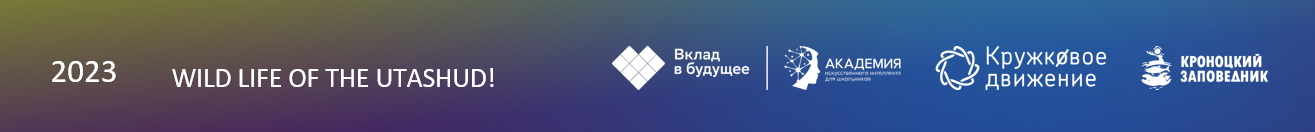

# **Wild life of the Utashud! About seagulls**

Using git, download YOLOv5, go to the folder with YOLO and install dependencies.

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15937, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 15937 (delta 26), reused 30 (delta 12), pack-reused 15880
Receiving objects: 100% (15937/15937), 14.66 MiB | 6.47 MiB/s, done.
Resolving deltas: 100% (10921/10921), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.8/613.8 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
%matplotlib notebook
%matplotlib inline

Importing Libraries

In [ ]:
from glob import glob
import torch
import utils
import cv2
from sklearn.metrics import mean_squared_error as mse
from PIL import Image
import random
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
display = utils.notebook_init()

YOLOv5 🚀 v7.0-213-g378ed74 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


# **Dataset download**


Downloading and unpacking the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/olimp/sber/newDataset.zip -d /content/yolov5/

# Data exploration

To begin with, let's see what is the average size of seagulls and how many of them in the photographs on average

In [ ]:
pathes = glob('/content/yolov5/train/labels/*')
nums = []
size_width = []
size_height = []

for pth in pathes:
    with open(pth, 'r') as f:
        nums.append(0)
        for line in f:
            nums[-1] += 1
            width, height = map(float, line.split(' ')[-2:])
            size_width.append(width*960)
            size_height.append(height*640)

print(f'Avarage number of the seagulls: {sum(nums)/len(nums)}')
print(f'Average size of the seagull: {sum(size_width)/len(size_width)}x{sum(size_height)/len(size_height)}')

Среднее количество чаек на фото Avarage number of the seagulls: 9.175292153589316
Средний размер чайки Average size of the seagull: 27.738673580786028x25.113173216885006


Let's build a heatmap of the most popular places among our seagulls.


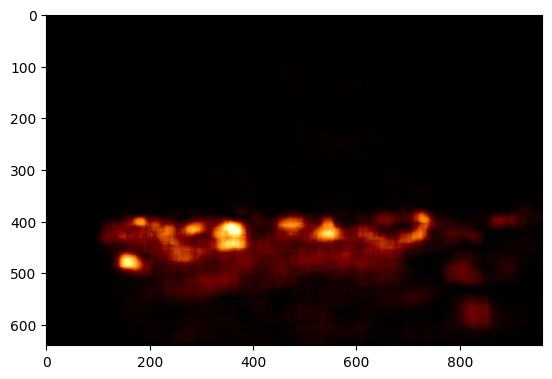

In [ ]:
heatmap = np.zeros((640, 960))
width = 960
height = 640
for pth in pathes:
    with open(pth, 'r') as f:
        for line in f:
            x, y, w, h = map(float, line.split(' ')[-4:])
            x_center = int(x * width)
            y_center = int(y * height)
            w = int(w * width)
            h = int(h * height)
            x1 = int(x_center - w / 2)
            y1 = int(y_center - h / 2)
            x2 = x1 + w
            y2 = y1 + h
            heatmap[y1:y2, x1:x2] += 1

plt.imshow(heatmap, cmap='afmhot')
plt.show()

Let`s have a look at the some photos.

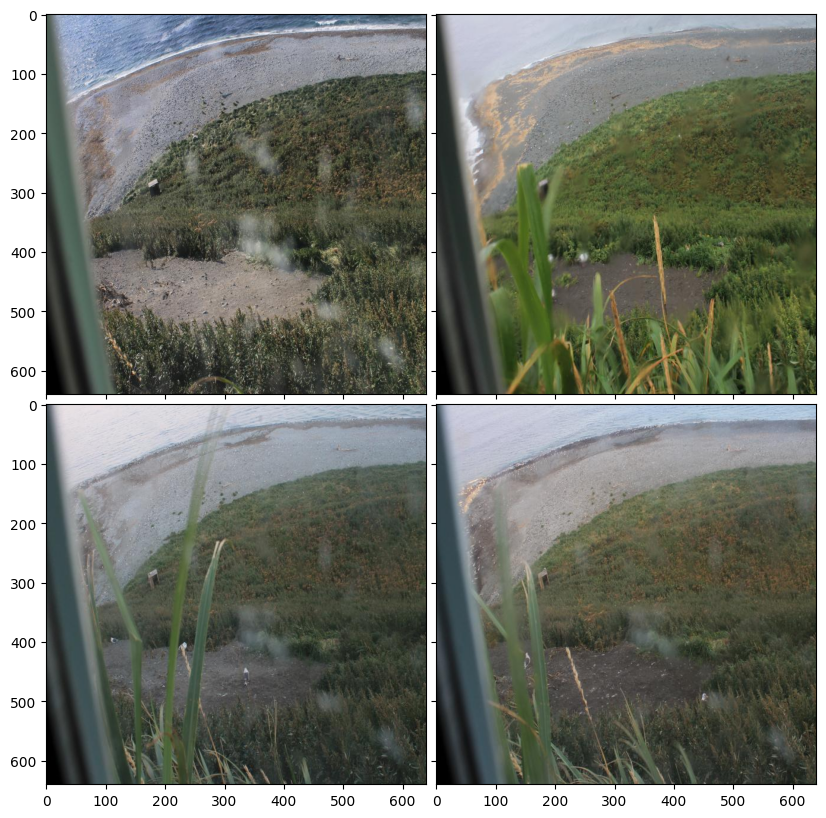

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('/content/yolov5/train/images/*') #пути ко всем файлам в папке
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)] #выбираем 4 случайных фото и переводим их в RGB (OpenCV хранит фото в цветовом окружение BGR)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

# Model training


For training, I decided to take the yolov5x model with an image size of 640 * 640, the maximum possible batch size (and this is -1 which automatically fills free space in RAM), 128 epochs.

In [ ]:
!python train.py --img 640 --batch -1 --epochs 128 --data data.yaml --weights yolov5x.pt --hyp data/hyps/hyp.scratch-high.yaml

# Model testing

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/last.pt --img 640 --conf 0.3 --source valid/images

We visualize the result in order to understand how good our model is

In [ ]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 2),
                 axes_pad=0.1,
                 )

pathes = glob('/content/yolov5/runs/detect/exp/*')
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.choices(pathes, k = 4)]

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

Calculate RMSE

In [ ]:
from sklearn.metrics import r2_score


model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt', force_reload=True)
model.conf = 0.3
model.agnostic = True
model.iou = 0.4
preds = []
y = []


for pth in glob(r'valid/images/*'):
    img = Image.open(pth)
    results = model(img)
    preds.append(results.xyxy[0].shape[0])
    f = open(pth.replace('images', 'labels')[:-3] + 'txt', 'r')
    y.append(len(list(f)))
    f.close()


print(f'RMSE = {mse(y, preds, squared=False)**0.5}')
print(f'r2_score = {r2_score(y, preds)}')

## Save our predictions

In [ ]:
import pandas as pd

paths = []
preds = []
for pth in glob('/content/gdrive/MyDrive/olimp/sber/images/*'):
    img = Image.open(pth)
    results = model(img)
    preds.append(results.xyxy[0].shape[0])
    paths.append(pth.split('/')[-1])

df = pd.DataFrame(list(zip(paths, preds)), columns=['filename', 'num'])

df

In [ ]:
df.to_csv('/content/sample_submission.csv', index=False)